In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
def gerar_dataset():
    num_amostras_classe_0 = 8
    num_amostras_classe_1 = 8
    num_amostras_classe_2 = 7


    x1_classe_0 = np.random.uniform(5, 10, num_amostras_classe_0)
    x2_classe_0 = np.random.uniform(0, 2.5, num_amostras_classe_0)
    labels_classe_0 = np.zeros(num_amostras_classe_0, dtype=int)


    x1_classe_1 = np.random.uniform(15, 20, num_amostras_classe_1)
    x2_classe_1 = np.random.uniform(6, 9, num_amostras_classe_1)
    labels_classe_1 = np.ones(num_amostras_classe_1, dtype=int)


    x1_classe_2 = np.random.uniform(0, 5, num_amostras_classe_2)
    x2_classe_2 = np.random.uniform(6, 10, num_amostras_classe_2)
    labels_classe_2 = np.full(num_amostras_classe_2, 2, dtype=int)


    x1 = np.concatenate((x1_classe_0, x1_classe_1, x1_classe_2))
    x2 = np.concatenate((x2_classe_0, x2_classe_1, x2_classe_2))
    labels = np.concatenate((labels_classe_0, labels_classe_1, labels_classe_2))


    dataset = pd.DataFrame({
        'x1': x1,
        'x2': x2,
        'Classe': labels
    })

    return dataset

In [3]:
artificial = gerar_dataset()
X = artificial[['x1', 'x2']]
y = artificial['Classe']

In [4]:
X = np.array(X)
y = np.array(y)

In [5]:
class BayesClassifierLinear:
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        self.means = {}
        self.cov = {}
        self.priors = {}
        
        for c in self.classes:
            X_c = X_train[y_train == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.cov[c] = np.cov(X_c.T)
            self.priors[c] = len(X_c) / len(X_train)
    
    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for c in self.classes:
                cov_inv = np.linalg.inv(self.cov[c])
                g = np.dot(x, cov_inv.dot(self.means[c])) - 0.5 * np.dot(self.means[c], cov_inv.dot(self.means[c])) + np.log(self.priors[c])
                posteriors.append(g)
            y_pred.append(np.argmax(posteriors))
        return y_pred

class BayesClassifierQuadratic:
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        self.means = {}
        self.cov = {}
        self.priors = {}
        
        for c in self.classes:
            X_c = X_train[y_train == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.cov[c] = np.cov(X_c.T)
            self.priors[c] = len(X_c) / len(X_train)
    
    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for c in self.classes:
                cov_inv = np.linalg.inv(self.cov[c])
                g = -0.5 * np.log(np.linalg.det(self.cov[c])) - 0.5 * np.dot((x - self.means[c]), np.dot(cov_inv, (x - self.means[c]))) + np.log(self.priors[c])
                posteriors.append(g)
            y_pred.append(np.argmax(posteriors))
        return y_pred

In [6]:
def confusionMatrix(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    num_classes = max(max(y_true), max(y_pred)) + 1
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true, pred in zip(y_true, y_pred):
        conf_matrix[true][pred] += 1

    return conf_matrix

In [7]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    test_samples = int(len(X) * test_size)
    X_train = X[indices[:-test_samples]]
    X_test = X[indices[-test_samples:]]
    y_train = y[indices[:-test_samples]]
    y_test = y[indices[-test_samples:]]
    return X_train, X_test, y_train, y_test

In [8]:
classifier_linear = BayesClassifierLinear()
classifier_quadratic = BayesClassifierQuadratic()

In [9]:
accuracyListLinear = []
accuracyListQuad = []
fileName = "Resultados/Artificial.txt"
with open(fileName, "w") as arquivo:
    for i in range(20):
        arquivo.write('\nIteração {}\n'.format(i))
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        # ---------------------------Linear---------------------------

        classifier_linear.fit(X_train, y_train)
        y_pred_linear = classifier_linear.predict(X_test)
        confMatrixLinear = confusionMatrix(y_test, y_pred_linear)
        accuracyL = np.trace(confMatrixLinear) / np.sum(confMatrixLinear)
        print('Acc(Linear):', accuracyL)
        accuracyListLinear.append(accuracyL)
        print('Confusion Matrix:\n', confMatrixLinear)
        arquivo.write("Acc:(Linear) {}\n".format(accuracyL))
        arquivo.write("Confusion Matrix: \n {} \n\n".format(confMatrixLinear))

        # ---------------------------Quadrático---------------------------

        classifier_quadratic.fit(X_train, y_train)
        y_pred_quadratic = classifier_quadratic.predict(X_test)
        confMatrixQuad = confusionMatrix(y_test, y_pred_quadratic)
        accuracyQ = np.trace(confMatrixQuad) / np.sum(confMatrixQuad)
        print('Acc(Quadrático):', accuracyQ)
        accuracyListQuad.append(accuracyQ)
        print('Confusion Matrix:\n', confMatrixQuad)
        arquivo.write("Acc(Quadrático): {}\n".format(accuracyQ))
        arquivo.write("Confusion Matrix: \n {} \n\n".format(confMatrixQuad))

    mean_accuracyLinear = np.mean(accuracyListLinear)
    best_realization_idx_linear = np.argmax(accuracyListLinear)

    mean_accuracyQuad = np.mean(accuracyListQuad)
    best_realization_idx_quad = np.argmax(accuracyListQuad)
    print('\nAcurácia média das 20 iterações linear: {:.2f} ± {:.2f}'.format(np.mean(accuracyListLinear), np.std(accuracyListLinear)))
    arquivo.write('\nAcurácia média das 20 iterações linear: {:.2f} ± {:.2f}'.format(np.mean(accuracyListLinear),np.std(accuracyListLinear)))
    arquivo.write('\nMelhor realização linear: {}'.format(best_realization_idx_linear))

    print('\nAcurácia média das 20 iterações quadrático: {:.2f} ± {:.2f}'.format(np.mean(accuracyListQuad),np.std(accuracyListQuad)))
    arquivo.write('\nAcurácia média das 20 iterações quadrático: {:.2f} ± {:.2f}'.format(np.mean(accuracyListQuad),np.std(accuracyListQuad)))
    arquivo.write('\nMelhor realização quadrático: {}'.format(best_realization_idx_quad))

FileNotFoundError: [Errno 2] No such file or directory: 'Resultados/Artificial.txt'

In [10]:
def plotDecisionSurface(xtrain, ytrain, classifierName, datasetName, linearOrQuad):
    atributesCombinationArtificial = [
        [0, 1]
    ]
    atributesCombinationIris = [
        [0, 1],
        [0, 2],
        [0, 3],
        [1, 2],
        [1, 3],
        [2, 3]
    ]
    atributesCombinationFree = [
        [0, 1],
        [0, 4],
        [0, 5],
        [2, 3],
        [3, 4],
        [4, 5]
    ]
    if datasetName == 'Iris':
        atributesCombination = atributesCombinationIris
    elif datasetName == 'Artificial':
        atributesCombination = atributesCombinationArtificial
    else:
        atributesCombination = atributesCombinationFree

    for z in atributesCombination:
        xtrainSelected = xtrain[:, z]
        x_min, x_max = xtrainSelected[:, 0].min() - 1, xtrainSelected[:, 0].max() + 1
        y_min, y_max = xtrainSelected[:, 1].min() - 1, xtrainSelected[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        matrix = np.c_[xx.ravel(), yy.ravel()]
        if linearOrQuad == "linear":
            model = BayesClassifierLinear()
        else:
            model = BayesClassifierQuadratic()
            
        model.fit(xtrainSelected, ytrain)
        Z = model.predict(matrix)

        Z = np.array(Z)
        Z = Z.reshape(xx.shape)
        fig, ax = plt.subplots()
        colors = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
        ax.contourf(xx, yy, Z, alpha=0.4, cmap=colors)
        x_vals = xtrainSelected[:, 0]
        y_vals = xtrainSelected[:, 1]
        ax.scatter(x_vals, y_vals, c=ytrain, s=20, edgecolor='k', cmap=colors)

        plt.title('Superfície de Decisão do {} base {}'.format(classifierName, datasetName))
        plt.xlabel('Atributo {}'.format(z[0]))
        plt.ylabel('Atributo {}'. format(z[1]))
        plt.show()

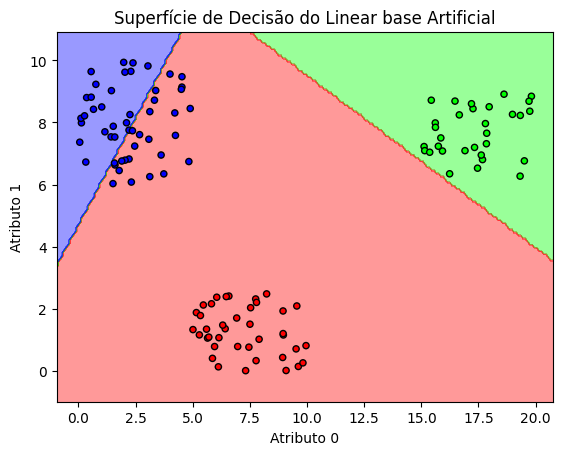

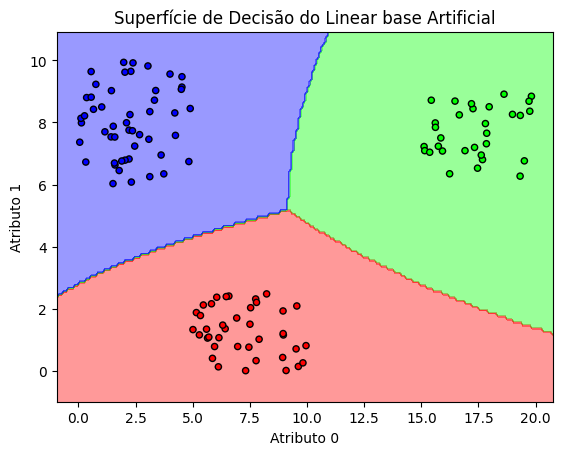

In [112]:
plotDecisionSurface(X_train,y_train,"Linear","Artificial", "linear")
plotDecisionSurface(X_train,y_train,"Linear","Artificial", "quad")